In [1]:
import torch
import numpy as np
import pandas as pd
import utils.constants as const

from sklearn.metrics import confusion_matrix
from utils.graph import draw_confusion_matrix
from utils.data_loader import get_unknown_data_loader
from utils.xception import Mos_Xception
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from openmax.openmax import OpenMax
from openmax.openmax_utils import convert_to_bin_label

from utils.data_split import get_species_map

/home/bit/miniforge3/envs/pace-up/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.15 (you have 1.4.10). Upgrade using: pip install --upgrade albumentations


In [2]:
device = torch.device('cuda:0')

In [3]:
f1_bin_list = []
pre_bin_list = []
rec_bin_list = []
acc_bin_list = []

f1_int_list = []
pre_int_list = []
rec_int_list = []
acc_int_list = []

In [4]:
species_map = get_species_map()
species_list = species_map.values()

In [5]:
y_true_list = []
y_pred_list = []

In [6]:
for fold in range(1, 6):
    model_path = f'model_weights/fold_{fold}/model.pth'
    data_csv_path = f'data/splits/data_fold_{fold}.csv'
    weibull_path = f'weibull_models/fold_{fold}/weibull_model.pkl'

    df = pd.read_csv(data_csv_path)
    test_dl = get_unknown_data_loader(df)

    net = Mos_Xception(const.NUM_CLASSES)
    net.load_state_dict(torch.load(model_path))
    net.to(device)
    net.eval()

    y_true_int = []

    for data in test_dl:
        for label in data[1].numpy():
            y_true_int.append(label)

    y_true_int = np.asarray(y_true_int)
    y_true_bin = convert_to_bin_label(y_true_int, const.NUM_CLASSES)

    om_wraper = OpenMax(net, weibull_path)
    y_pred_int = om_wraper.predict(test_dl)
    y_pred_bin = convert_to_bin_label(y_pred_int, const.NUM_CLASSES)

    y_true_list.append(y_true_int.ravel().tolist())
    y_pred_list.append(y_pred_int.ravel().tolist())

    f1_bin = f1_score(y_true_bin, y_pred_bin)
    pre_bin = precision_score(y_true_bin, y_pred_bin)
    rec_bin = recall_score(y_true_bin, y_pred_bin)
    acc_bin = accuracy_score(y_true_bin, y_pred_bin)

    f1_int = f1_score(y_true_int, y_pred_int, average='macro')
    pre_int = precision_score(y_true_int, y_pred_int, average='macro')
    rec_int = recall_score(y_true_int, y_pred_int, average='macro')
    acc_int = accuracy_score(y_true_int, y_pred_int)

    f1_bin_list.append(f1_bin)
    pre_bin_list.append(pre_bin)
    rec_bin_list.append(rec_bin)
    acc_bin_list.append(acc_bin)

    f1_int_list.append(f1_int)
    pre_int_list.append(pre_int)
    rec_int_list.append(rec_int)
    acc_int_list.append(acc_int)

In [7]:
y_true_list = sum(y_true_list, [])
y_pred_list = sum(y_pred_list, [])

In [8]:
cm = confusion_matrix(y_true_list, y_pred_list, normalize='true')
cm = np.round(cm, 2)

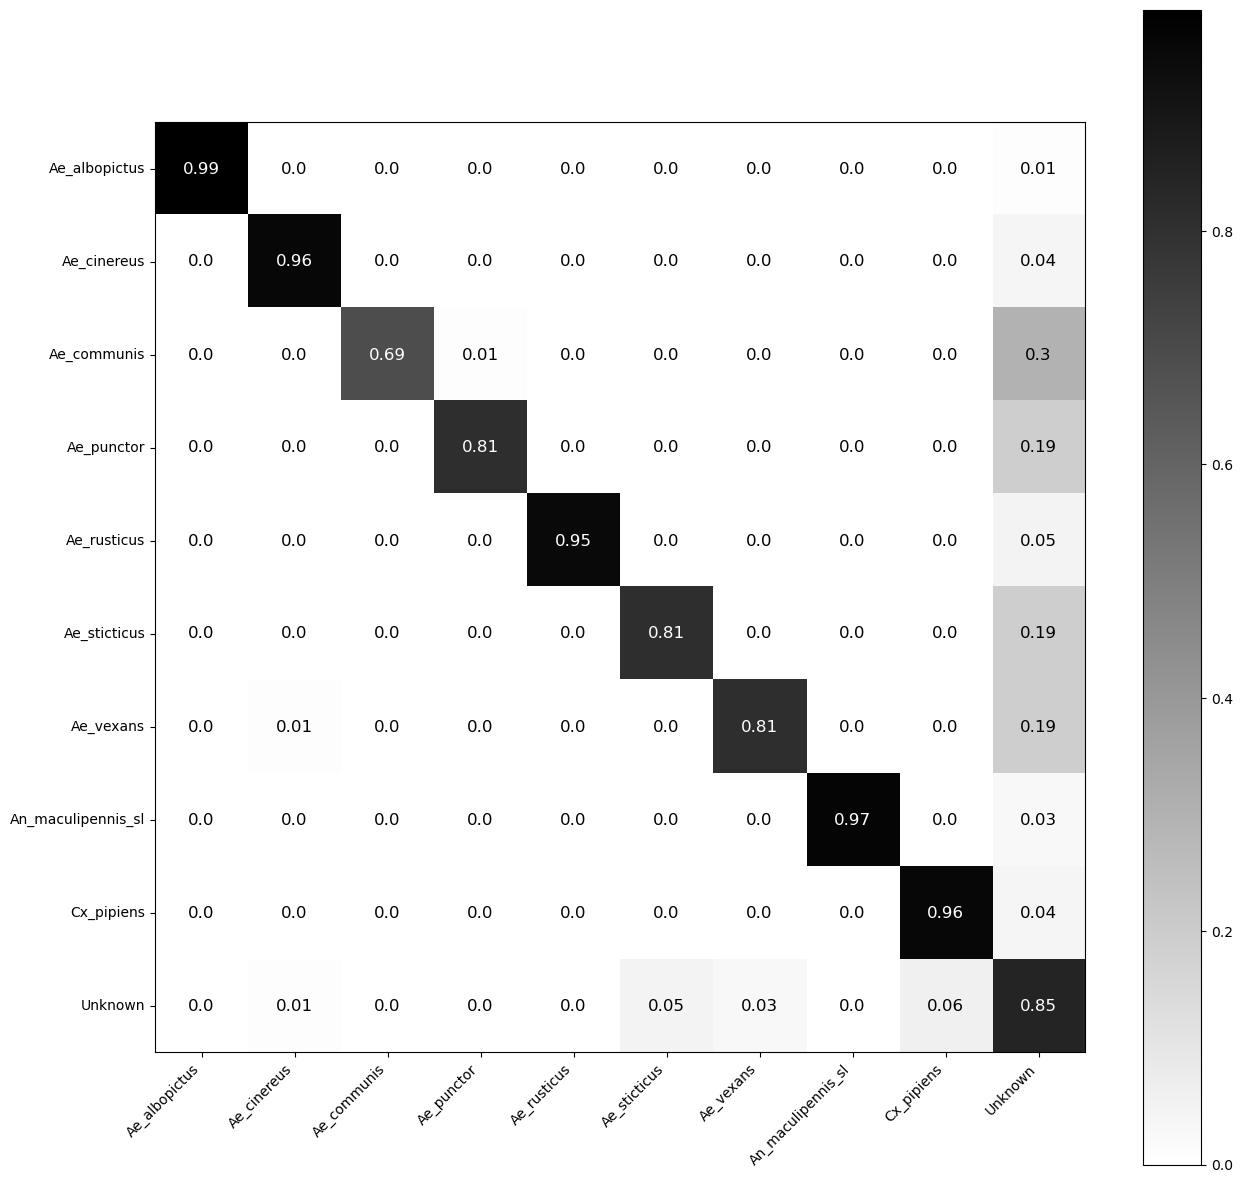

In [9]:
draw_confusion_matrix(cm, species_list)

In [10]:
metrics_df = pd.DataFrame()
metrics_df['f1_bin'] = f1_bin_list
metrics_df['pre_bin'] = pre_bin_list
metrics_df['rec_bin'] = rec_bin_list
metrics_df['acc_bin'] = acc_bin_list

metrics_df['f1_int'] = f1_int_list
metrics_df['pre_int'] = pre_int_list
metrics_df['rec_int'] = rec_int_list
metrics_df['acc_int'] = acc_int_list

In [11]:
metrics_df.to_csv('results/metrics.csv', index=False)